Building a model is not enough. We need to judge whether our model fit the data well. If the model fits, then the replicated data under the model should look similar to observed data.

The basic technique for checking the fit of a model is to draw simulated values from the posterior predictive distributio of data and compared these samples to the observed data. Any systematic differences between the simulations and the data indicate a potential failings of the model.

In this notebook, we will fit a model and perform model checking.

**Problem**: Simon Newcomb set up an experiment to measure the speed of light. Newcomb measures the amount of time required for light to travel a distance of 7442 meters. Our data includes 66 measurements.

# Model Construction

We will use the normal model, which is a poor model for this problem. Specifically, we assume that the 66 measurements are independent draws froma normal distribution with mean $\mu$ and variance $\sigma^2$. The main goal is posterior inference for $\mu$.

Using a noninformative prior $p(\mu, \sigma^2) \propto (\sigma^2)^{-1}$, we have the posterior distribution of $\mu$:

$$\mu \mid y \sim t_{n-1}(\bar{y}, s^2/n),$$

where $s^2 = \frac{1}{n-1}\sum_{i=1}^{n}(y_i - \bar{y})^2$ is the unbiased sampled variance.



In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['figure.figsize'] = (12,8)

In [53]:
import os, sys
# add utilities directory to path
util_path = os.path.abspath('/Users/totucuong/work/code/machine-learning/my_bayesian_data_analysis/utilities_and_data')
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import plot_tools

In [55]:
y = np.loadtxt('./light.txt')
# sufficient statistics
n = len(y)
s2 = np.var(y, ddof=1)  # ddof=1 -> sample estimate
my = np.mean(y)

# filtered data
y_pos = y[y > 0]
# sufficient statistics
n_pos = len(y_pos)
s2_pos = np.var(y_pos, ddof=1)
my_pos = np.mean(y_pos)

In [56]:
# # for mu, compute the density in these points
# tl1 = [10, 40]
# t1 = np.linspace(tl1[0], tl1[1], 100)

# # compute the exact marginal density for mu
# # multiplication by 1./sqrt(s2/n) is due to the transformation of variable
# # z=(x-mean(y))/sqrt(s2/n), see BDA3 p. 21
# pm_mu = stats.t.pdf((t1 - my) / np.sqrt(s2/n), n-1) / np.sqrt(s2/n)

# # compute the exact marginal density for mu for the filtered data
# pm_mu_pos = (
#     stats.t.pdf((t1 - my_pos) / np.sqrt(s2_pos/n_pos), n_pos-1) /
#     np.sqrt(s2_pos/n_pos)
# )

# Easier to understand, density of mu is computed directly without using transformation
# for mu, compute the density in these points
tl1 = [10, 40]
t1 = np.linspace(tl1[0], tl1[1], 100)

pm_mu = stats.t.pdf(t1, n-1, loc=my, scale=np.sqrt(s2/n))

# compute the exact marginal density for mu for the filtered data
pm_mu_pos = stats.t.pdf(t1, n_pos-1, loc=my_pos, scale=np.sqrt(s2_pos/n_pos))

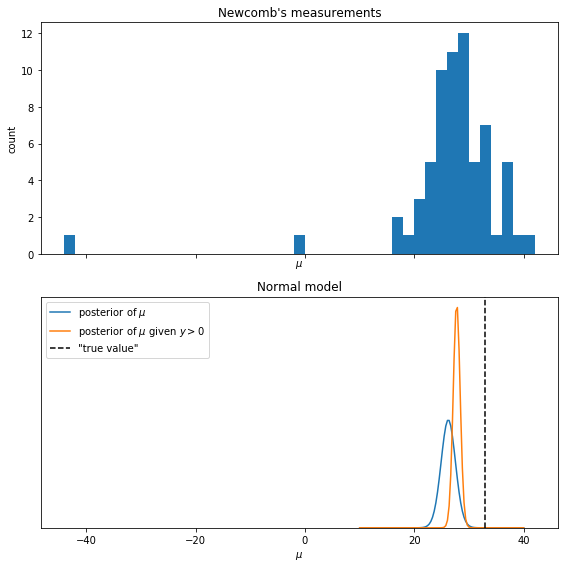

In [57]:
# Plotting

# create figure
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

# plot histogram
ax = axes[0]
ax.hist(y, np.arange(-44, 43, 2))
# decorate
ax.set_title('Newcomb\'s measurements')
ax.set_ylabel('count')
ax.set_xlabel('$\mu$')
plt.setp(axes[0].get_xticklabels(), visible=True)

# plot the posterior of mu
ax = axes[1]
ax.plot(t1, pm_mu)
# plot the posterior of mu in the filtered case
ax.plot(t1, pm_mu_pos)
# Plot the currently accepted true value
ax.axvline(33, color='k', linestyle='--')
ax.legend(
    ('posterior of $\mu$',
     'posterior of $\mu$ given $y > 0$',
     '"true value"'),
    loc='upper left'
)
ax.set_title('Normal model')
ax.set_xlabel('$\mu$')
ax.set_yticks(())
# set bottom to zero
ax.set_ylim((0, ax.set_ylim()[1]))

fig.tight_layout()

The 95% interval of $\mu$ is

In [58]:
lower = stats.t.ppf(0.025,n_pos-1, loc=my, scale=np.sqrt(s2/n))
upper = stats.t.ppf(0.975,n_pos-1, loc=my, scale=np.sqrt(s2/n))
print('95% interval [{},{}]'.format(lower,upper))

95% interval [23.56900001105432,28.8552424131881]


We could also computed the 95% interval using simulation. Drawing 1000 samples from $p(\sigma^2 \mid y)$ and then given this value of $\sigma^2$, we draw $\mu$ from $p(\mu, \mid \sigma^2, y)$

We see that the true value of $\mu$ falls out of our 95% interval. This shows that our model poorly fits the data. Why is that? Notice on the histogram of Newcomb's measurements, we have two outlier

# Model Checking

#### Posterior predictive checking

If the model fits, then replicated data generated under the model should look familiar to observed data.

Again we use the light speed case. We have the posterior predictive distribution  $p(\tilde{y} \mid y)$ is a t distribution with location $\bar{y}$ and scale $(1 + 1/n)^{1/2}s$, and (n-1) degree of freedom.

In [71]:
# Create 9 random replicate data sets from the posterior predictive density.
# Each set has same number of virtual observations as the original data set.
s = np.sqrt(s2)
replicates = np.random.standard_t(n-1, size=(9,n)) * np.sqrt(1+1/n)*s + my

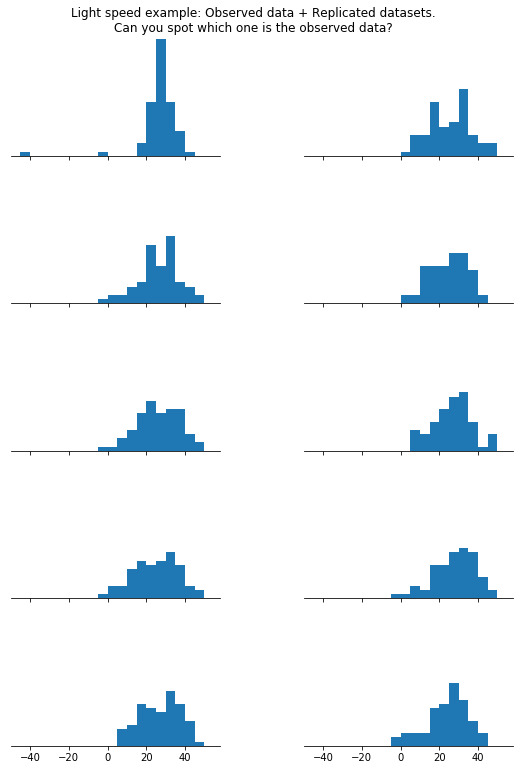

In [72]:
# plot them along with the real data set in random order subplot
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(9, 12))
fig.subplots_adjust(top=0.95, wspace=0.4)
order = np.random.permutation(10)
for i, ax in enumerate(axes.flat):
    ax.hist(
        replicates[order[i]] if order[i] < 9 else y,
        np.arange(-45, 55, 5)
    )
    plot_tools.modify_axes.only_x(ax)
axes[0, 0].set_xlim([-50, 58])
fig.suptitle(
    "Light speed example: Observed data + Replicated datasets.\n"
    "Can you spot which one is the observed data?"
);

We can see easily spot the histogram of observed data due to its two outliers. This means the replicated data are signficant different from the observed data. Our model does not fit data well.

#### Compare the minimum of the real data set into the minimum of a replicated dataset.

The distribution of the minimum value of a replicated data set can be 
calculated analytically. Consider $n$ samples of $X_i$, where $X_i$ has cumulative distribution function $F(x)$ and probability distribution function $f(x)$. The cumulative distribution function of the minimum of the $n$ samples is $1 - (1 - F(x))^n$ and the probability distribution function is its derivative $n f(x) (1 - F(x))^{n-1}$.

In [73]:
# Calculate the pdf of the minumum of a replicated dataset
x = np.linspace(-60, 20, 150)
pdf = stats.t.pdf(x, df=n-1, loc=my, scale=np.sqrt(s2*(1+1/n)))
cdf = stats.t.cdf(x, df=n-1, loc=my, scale=np.sqrt(s2*(1+1/n)))
pdf_min = n * pdf * (1 - cdf)**(n-1)

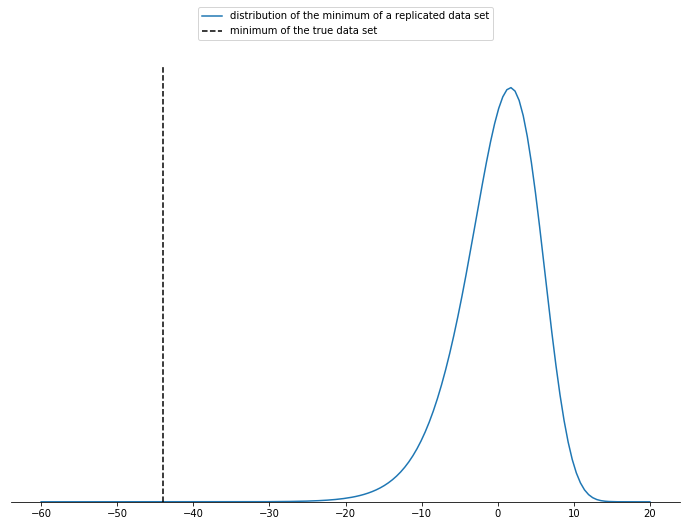

In [74]:
# Plot the real minimum and the distribution of the min of a replicate data set
plt.figure()
plot_tools.modify_axes.only_x(plt.gca())
plt.plot(
    x,
    pdf_min,
    label='distribution of the minimum of a replicated data set'
)
plt.ylim([0, plt.ylim()[1]])  # set y base to zero
plt.axvline(
    y.min(),
    color='k',
    linestyle='--',
    label='minimum of the true data set'
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05));

# Quantifying the lack-of-fit of a model

We measure the discrepancy between model and data by defining **test quantities**, the aspect of the data we wish to check.

**Test quantity** $T(y, \theta)$ is the generalization of test statistics in classical testing  $T(y)$. As we see the test quantiy depends  not only on the data $y$ but also on parameters. Test quantity is a scalar summary of parameters and data that is used as a standard when comparing data to predictive simulations.

**Tail-area probabilities**: lack of fit of the data with respect to the posterior predictive distribution can be measured by the tail-area probability, or **p-value**, of the test quantity. There are classical and Bayesian p-values.

**Classical p-values** for thtest statistics T(y) is $$p_C = Pr(T(y^{rep} \geq T(y) \mid \theta)$$ where the probability is taken over the distribution of $y^{rep}$ with $\theta$ fixed.

**Bayesia p-value** is defined as the probability that the replicated data could be more extreme than the observed data, as measured by the test quantity $$\begin{align}p_B &= Pr(T(y^{rep}, \theta) \geq T(y, \theta) \mid y)\\
&= \int \int I_{T(y^{rep}, \theta) \geq T(y, \theta)}p(y^{rep}, \theta)dy^{rep}d\theta\\
&= \int \int I_{T(y^{rep}, \theta) \geq T(y, \theta)}p(y^{rep}|\theta)p(\theta|y)dy^{rep}d\theta
\end{align}$$

Note that $p(y^{rep}\mid \theta, y)=p(y^{rep} \mid \theta)$


**Test quantity computation**: In practice, the estimated p-value is just the proportion of S simulations for which the test quantiy equals or exceeds its realized value; that is, for which $T(y^{rep\,s}, \theta^s) \geq T(y, \theta^s), s = 1\dots S$

#### Choosing a good test statistics
It is important to select a good test quantity. In the light speed examples, sample variance is not a good statistics since it is itself a sufficient statistics for the model. Recall that have the posterior predictive distribution  $p(\tilde{y} \mid y)$ is a t distribution with location $\bar{y}$ and scale $(1 + 1/n)^{1/2}s$, and (n-1) degree of freedom.

Without an informative prior distribution, the posterior distribution of will automatically be centered around the observed value.

In [80]:
# A second example of replications
nsamp = 1000
pps = np.random.standard_t(n-1, size=(n,nsamp))*np.sqrt(s2*(1+1/n)) + my
# Use the sample variance as a test statistic
# This is a poor choice since it corresponds directly to
# the variance parameter in the model which has been fitted
# to the data.
pp = np.var(pps, axis=0, ddof=1)

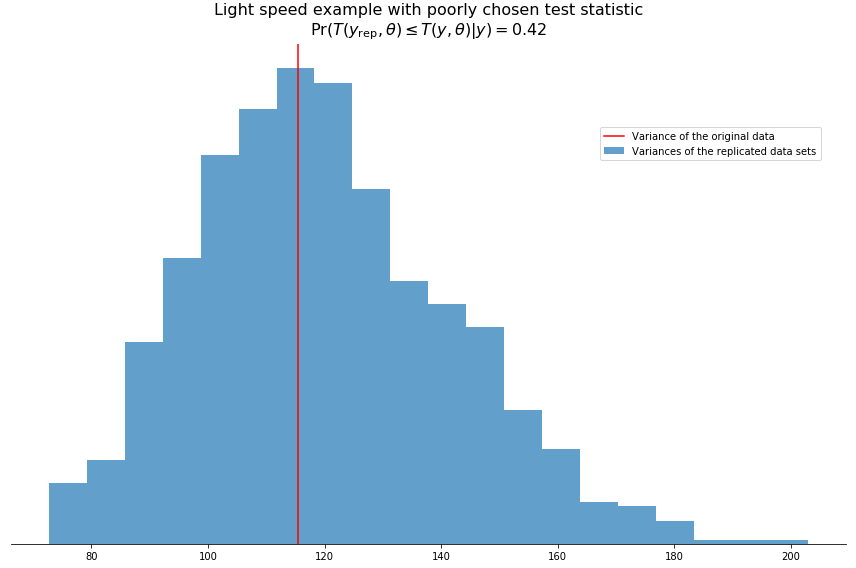

In [81]:
# plot
plt.hist(
    pp,
    20,
    label='Variances of the replicated data sets',
    color=plot_tools.lighten('C0', 0.3)
)
plt.axvline(s2, color='red', label='Variance of the original data')
plt.title(
    'Light speed example with poorly chosen test statistic\n'
    r'$\operatorname{Pr}(T(y_\mathrm{rep},\theta)\leq T(y,\theta)|y)=0.42$',
    fontsize=16
)
plt.legend(loc='center left', bbox_to_anchor=(0.7, 0.8))
plot_tools.modify_axes.only_x(plt.gca())
plt.tight_layout()

In [83]:
# Testing sequential dependence example (Gelman et al p. 163)
y = np.array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])
Ty = np.count_nonzero(np.diff(y))

# sufficient statistics
n = len(y)
s = y.sum()

nsamp = 10000
t = np.random.beta(s+1, n-s+1, size=nsamp)
yr = np.random.rand(n, nsamp) < t
# sadly np.count_nonzero does not (yet) support axis parameter
Tyr = (np.diff(yr, axis=0) != 0).sum(axis=0)

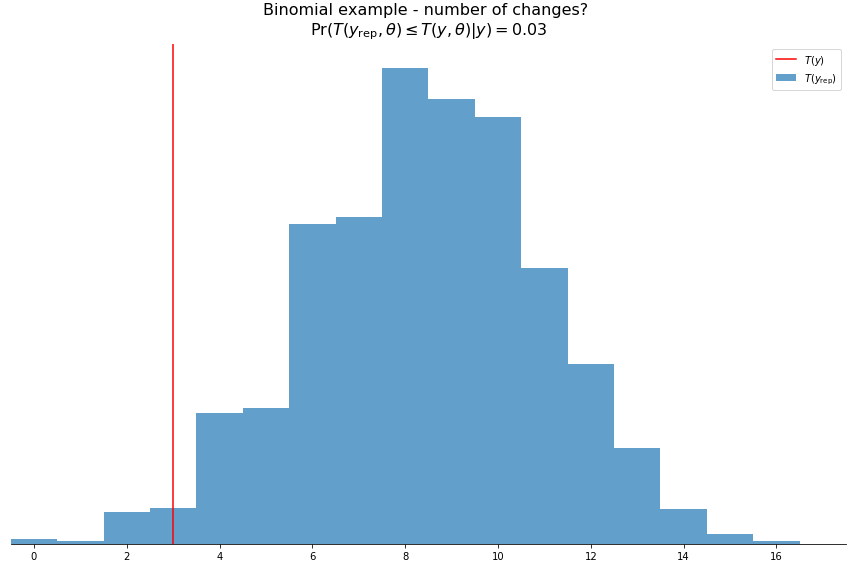

In [84]:
# plot
plt.hist(
    Tyr,
    np.arange(19),
    align='left',
    label='$T(y_\mathrm{rep})$',
    color=plot_tools.lighten('C0', 0.3)
)
plt.axvline(Ty, color='red', label='$T(y)$')
plt.xlim((-0.5, 17.5))
plt.title(
    'Binomial example - number of changes? \n'
    r'$\operatorname{Pr}(T(y_\mathrm{rep},\theta) \leq T(y,\theta)|y) = 0.03$',
    fontsize=16
)
plt.legend()
plot_tools.modify_axes.only_x(plt.gca())
plt.tight_layout()

# Interpreting posterior predictive p-values

A models is suspect of a discrepancy is of practical importance and its observed value has a tail-area probability near 0 or 1, indicating the observed pattern (data) would be unlikely to be seen in replications of the data if the model were true.

An extreme p-value impolies themodel cannot be expected to capture this aspect of the data: variance of data, outlier of data, etc.

If a p-value is close to 0 or 1, it is not so important exactly how extreme it is. A p-value of 0.00001 is vritually no stronger, in practice, than 0.001. Both shows that the aspect of the data measured by the test quantity is inconsistent with the model.

A reasonable range is between (0.05 and 0.95). 

The p-values measures **statistical significance** not **practical significance**. 